In [1]:
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import correlate2d
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import ast
import time
import pandas as pd
import random

Matplotlib is building the font cache; this may take a moment.


In [2]:
def video_frames_count(filename):
    cap = cv2.VideoCapture(filename)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [3]:
def normalize_list_sklearn(lst):
    scaler = MinMaxScaler()
    return scaler.fit_transform([[x] for x in lst]).flatten()

In [4]:
def extract_frames(video_path, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Open the video file
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise ValueError(f"Error opening video file: {video_path}")
    
    frame_count = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        
        # Save the frame as an image file
        frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_filename, frame)
        
        frame_count += 1
    
    # Release the video capture object
    video.release()
    
    print(f"Extracted {frame_count} frames to '{output_folder}'")
    return frame_count

In [5]:
def compare_images(func, image_path1, image_path2):
    # Read the images
    image1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
    image2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
    
    # Check if images were loaded correctly
    if image1 is None or image2 is None:
        raise ValueError("One or both image paths are invalid or the images cannot be read.")
    
    # Resize images to the same dimensions, if necessary
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    
    if func == 'histogram':
        hist1 = cv2.calcHist([image1], [0], None, [256], [0, 256])
        hist2 = cv2.calcHist([image2], [0], None, [256], [0, 256])
        similarity = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    
    elif func == 'cor3':
        # Calculate correlation
        image1 = image1.flatten()
        image2 = image2.flatten()
        similarity = np.corrcoef(image1, image2)[0,1]
    
    return similarity

In [6]:
def similarity_Signal(func):
    simSig = []

    image_path1 = 'output_frames_'+video_name+'/frame_0001.jpg'
    for i in range(totalFrames):
        image_path2 = 'output_frames_'+video_name+'/frame_' + f"{i:04}" +".jpg"
        
        simSig.append(compare_images(func,image_path1, image_path2))
    
    return simSig

In [7]:
def plot_similarity(sim_metric, y_values, y_range):
    x = np.linspace(0, totalFrames, totalFrames)
    y = y_values
    
    # Create the plot
    plt.plot(x, y, label=sim_metric)
    plt.ylim(y_range[0], y_range[1])
    
    # Add labels and title
    plt.xlabel("frame")
    plt.ylabel("similarity")
    plt.title("Frames Similarities to frame 0001")
    
    # Add a legend
    plt.legend()
    
    # Show the grid
    plt.grid()
    
    # Display the plot
    plt.show()

In [8]:
def subplot_similarity(subpl, sim_metric, y_values, y_range):
    x = np.linspace(0, totalFrames, totalFrames)
    y = y_values
    
    # Create the plot
    plt.subplot(2, 1, subpl)
    plt.plot(x, y, label=sim_metric)
    plt.ylim(y_range[0], y_range[1])
    
    # Add labels and title
    plt.xlabel("frame")
    plt.ylabel("similarity")
    plt.title("Frames Similarities to frame 0001")
    
    # Add a legend
    plt.legend()
    
    # Show the grid
    plt.grid()
    
    # Display the plot
    plt.show()

In [9]:
def second_max_index(arr):
    # Find the index of the maximum value
    max_index = np.argmax(arr)

    # Create a copy of the array and set the maximum value to negative infinity
    arr_copy = np.copy(arr)
    arr_copy[max_index] = -np.inf

    # Find the index of the second maximum value
    second_max_index = np.argmax(arr_copy)

    return second_max_index

In [10]:
def find_period(signal):
    # Sample data
    x = np.linspace(0, totalFrames, totalFrames)
    y = signal

    # Calculate FFT
    yf = fft(y)
    xf = fftfreq(len(y), x[1] - x[0])
  
    # Find the dominant frequency
    dominant_frequency = xf[second_max_index(np.abs(yf))]
    
    # Calculate the period
    period = 1 / dominant_frequency
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 2)
    plt.plot(x, y)
    plt.title('Original Signal')

    #xf = np.where(xf >= 0)
    
    plt.subplot(2, 2, 1)
    plt.plot(xf, np.abs(yf))
    plt.title('FFT')
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    print("\t\t\tDominant Frequency: %.3f , Period: %.3f" %(dominant_frequency, period))

In [11]:
def autoCorrelation(signal):
    fs = totalFrames  # Sampling rate
    
    t = np.arange(0, 1, 1/fs) # Time vector
    t = t[:len(signal)]
    

    autocorr = np.correlate(signal, signal, mode='full')
    autocorr = autocorr[len(signal)-1:] # Only take positive lags

    peaks = np.diff(np.sign(np.diff(autocorr))) < 0 # Find local maxima
    peak_indexes = np.where(peaks)[0] + 1
    
    if len(peak_indexes) <= 0:
        print("\t\t\tNo clear period found.")
        period = 0
    else:
      
        period = peak_indexes[0] / fs # Period in seconds
        print(f"\t\tPeriod: {(totalFrames/25)*period:.3f} seconds" ,end = "")
        print(f"\tPeriod: {totalFrames*period:.3f} frames") # 25 frames / second
        
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 2)
    plt.plot(t*(totalFrames/25), signal)
    plt.title("Signal")

    plt.subplot(2, 2, 1)
    plt.plot((totalFrames/25)*np.arange(len(autocorr))/fs, autocorr)
    plt.title("Autocorrelation")
    plt.xlabel("Lag (seconds)")
    plt.scatter((totalFrames/25)*period, autocorr[int(period*fs)], color='red', marker='o', label=f'Period: {(totalFrames/25)*period:.3f} s')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
def cepstrumAnalysis(signal):
    # Define the signal
    fs = totalFrames  # Sampling frequency
    
    t = np.arange(0, 1, 1/fs) # Time vector
    t = t[:len(signal)]
    
    # Calculate the cepstrum
    spectrum = np.fft.fft(signal)
    log_spectrum = np.log(np.abs(spectrum))
    cepstrum = np.fft.ifft(log_spectrum)
    
    # Identify the peak
    cepstrum = np.abs(cepstrum) # Take the absolute value to get the real cepstrum
    peak_index = np.argmax(cepstrum[3:-3]) + 3 # Exclude first 5 samples
    
    # Calculate the period
    period = peak_index / fs
    
    # Plot the signal and the cepstrum
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 2, 2)
    plt.plot((totalFrames/25)*t, signal)
    plt.title('Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 2, 1)
    plt.plot((totalFrames/25)*np.arange(len(cepstrum))/fs, cepstrum)
    plt.title('Cepstrum')
    plt.xlabel('Quefrency (s)')
    plt.ylabel('Amplitude')
    plt.axvline(x=(totalFrames/25)*period, color='r', linestyle='--', label=f'Period = {(totalFrames/25)*period:.3f} s')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\t\tPeriod: {(totalFrames/25)*period:.3f} seconds\tPeriod: {totalFrames*period:.3f} frames")


In [13]:
def read_signal_file(file_name):
    # opening the file in read mode 
    my_file = open(file_name, "r")

    data = my_file.read() 
    data_into_list = data.replace(']', ']\n')
    data_into_list = data_into_list.replace('np.float64(','(')
    data_into_list = data_into_list.split('\n')
    my_file.close()
    return data_into_list

In [14]:
def write_signal_file(file_name):
    with open(file_name, 'w') as output:
      
        signal = similarity_Signal('histogram')
        output.write(str(signal))
        
        signal = similarity_Signal('cor3')
        output.write(str(signal))

In [15]:
video_name = 'v_pendulum7'
video_ext = '.webm'

In [104]:
totalFrames = extract_frames(video_name+video_ext, 'output_frames_'+video_name)

Extracted 600 frames to 'output_frames_v_pendulum7'


In [17]:
write_signal_file('signals_'+video_name+'.txt')

In [16]:
totalFrames = 600

In [18]:
data_into_list = read_signal_file('signals_'+video_name+'.txt')

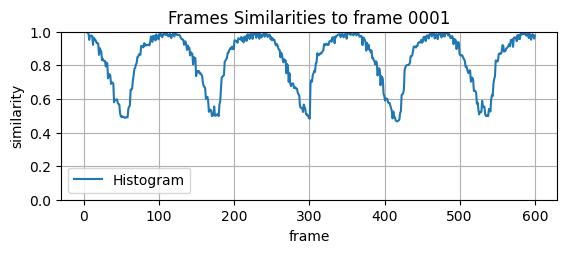

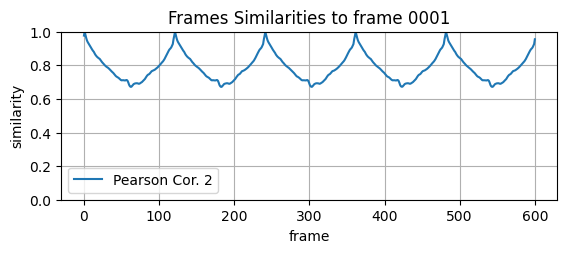

In [19]:
subplot_similarity(1,'Histogram', ast.literal_eval(data_into_list[0]), (0,1))
subplot_similarity(1,'Pearson Cor. 2', ast.literal_eval(data_into_list[1]), (0,1))

In [20]:
ls_Histogram = ast.literal_eval(data_into_list[0])
ls_PearsonCor2 = ast.literal_eval(data_into_list[1])

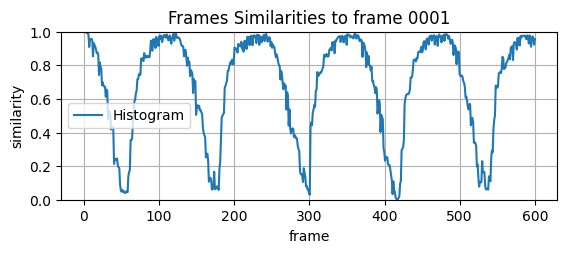

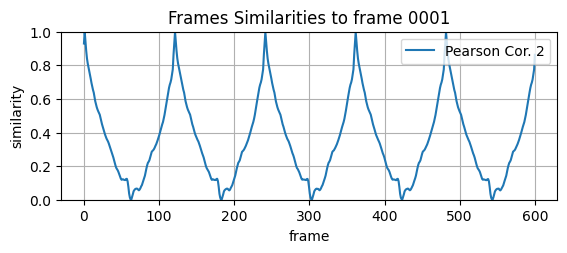

In [21]:
subplot_similarity(1,'Histogram', normalize_list_sklearn(ast.literal_eval(data_into_list[0])), (0,1))
subplot_similarity(1,'Pearson Cor. 2', normalize_list_sklearn(ast.literal_eval(data_into_list[1])), (0,1))

			No clear period found.


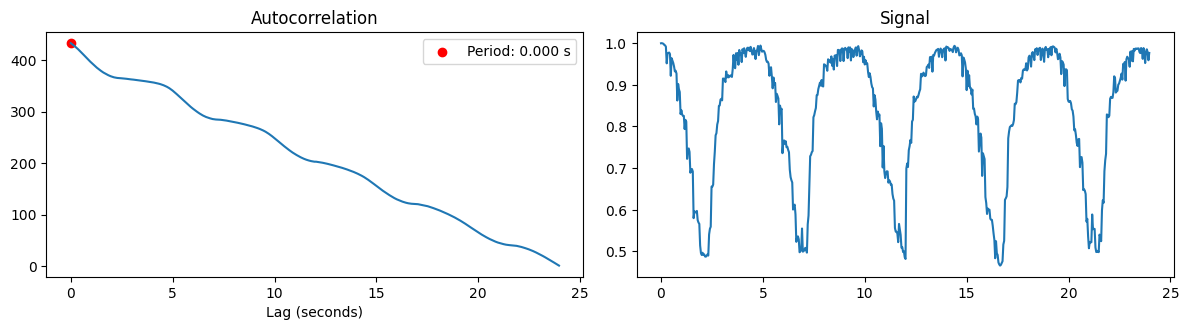

			No clear period found.


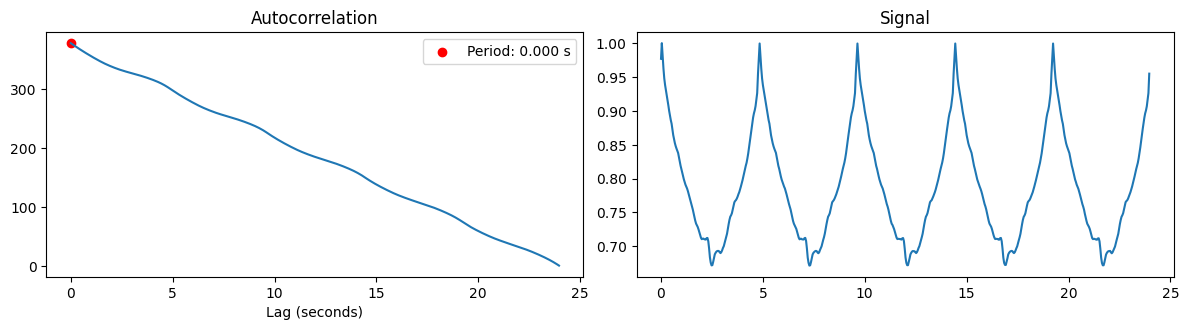

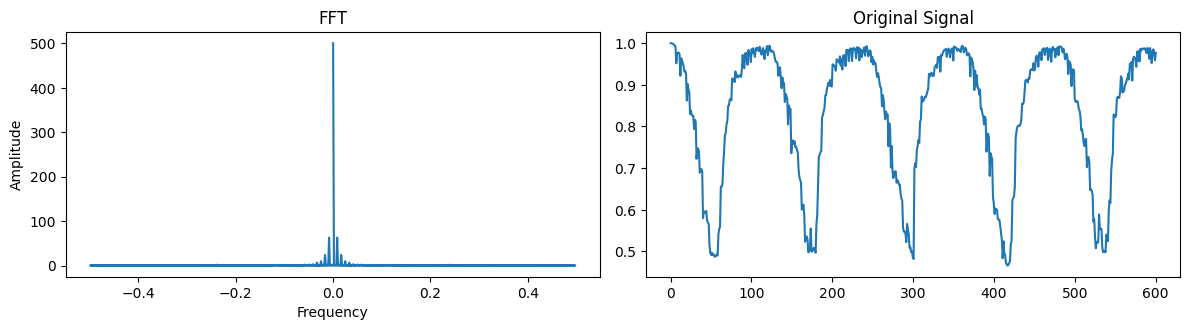

			Dominant Frequency: 0.008 , Period: 120.200


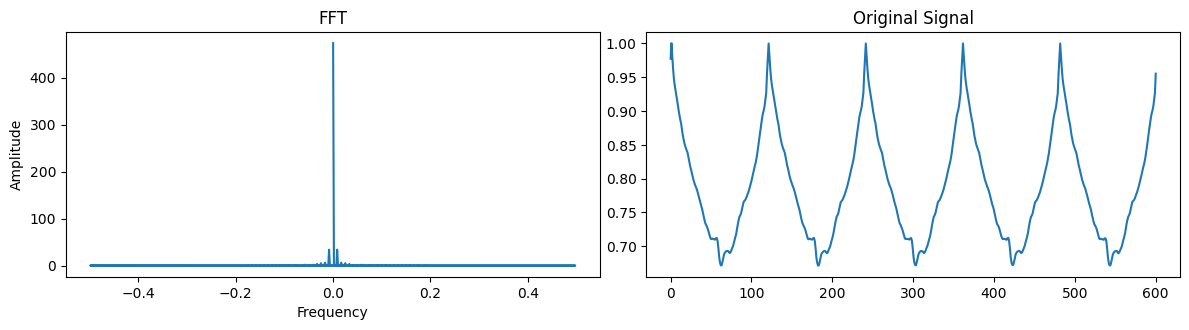

			Dominant Frequency: 0.008 , Period: 120.200


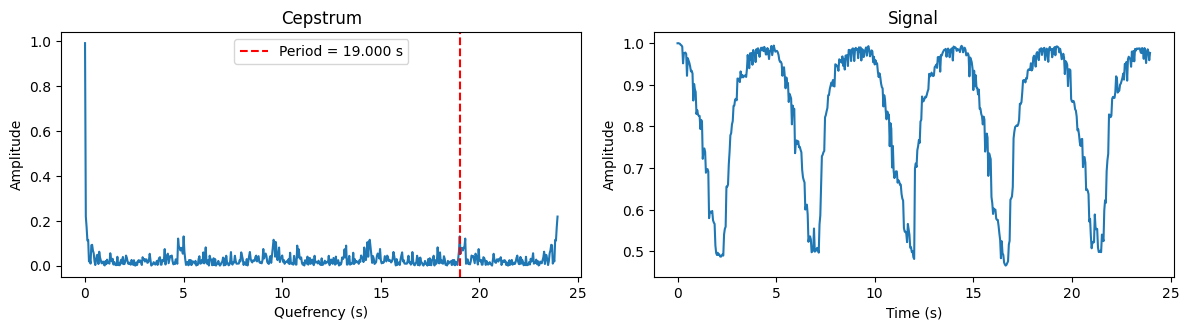

		Period: 19.000 seconds	Period: 475.000 frames


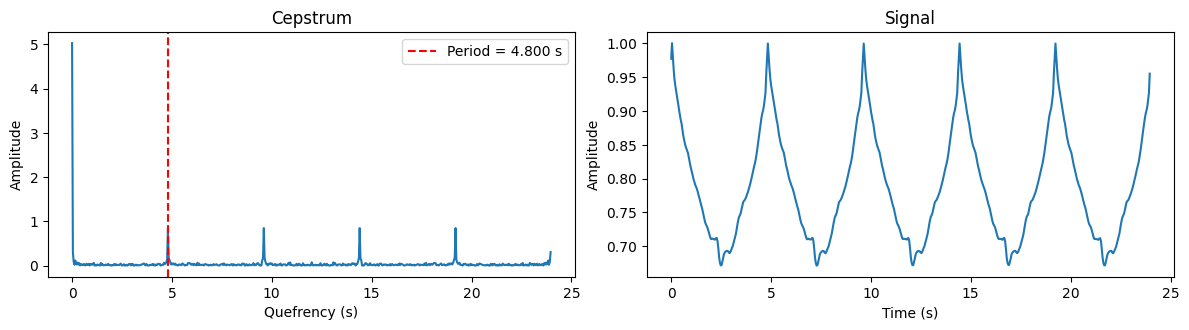

		Period: 4.800 seconds	Period: 120.000 frames


In [22]:
autoCorrelation(ls_Histogram)
autoCorrelation(ls_PearsonCor2)

find_period(ls_Histogram)
find_period(ls_PearsonCor2)

cepstrumAnalysis(ls_Histogram)
cepstrumAnalysis(ls_PearsonCor2)